## Machine Learning Model: Neural Network

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

# Python SQL toolkit and Object Relational Mapper dependencies.
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
import psycopg2
from psycopg2 import sql, connect, Error

from config import db_password

import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
# Query to extract data from insurance_claims table in Postgres
# Code adapted from https://pynative.com/python-postgresql-select-data-from-table/

# Create a global string for the PostgreSQL db name
db_name = "insurance_fraud_db"

# Connect to an existing database
connection = psycopg2.connect(user="postgres",
                              password=db_password,
                              host="127.0.0.1",
                              port="5432",
                              database=db_name)

# Create a cursor to perform database operations
cursor = connection.cursor()

# Executing a SQL query
cursor.execute("SELECT * FROM insurance_claims")

# Fetch result
record = cursor.fetchall()

# Close connections
cursor.close()
connection.close()

In [3]:
# Query to extract column headers from insurance_claims table in Postgres
# Code adabpted from https://kb.objectrocket.com/postgresql/
# "Get The Column Names From A PostgreSQL Table with the Psycopg2 Python Adapter"

try:
    # declare a new PostgreSQL connection object
    conn = psycopg2.connect(user="postgres",
                              password=db_password,
                              host="127.0.0.1",
                              port="5432",
                              database=db_name)

except Exception as err:
    print ("psycopg2 connect() ERROR:", err)
    conn = None
    
# define a function that gets the column names from a PostgreSQL table
def get_columns_names(table):

    # declare an empty list for the column names
    columns = []

    # declare cursor objects from the connection    
    col_cursor = conn.cursor()

    # Select string for query to get column names
    col_names_str = "SELECT column_name FROM information_schema.columns WHERE table_name = 'insurance_claims' ORDER BY ordinal_position"

    try:
        sql_object = sql.SQL(
            # pass SQL statement to sql.SQL() method
            col_names_str
        ).format(
            # pass the identifier to the Identifier() method
            sql.Identifier( table )
        )

        # execute the SQL string to get list with col names in a tuple
        col_cursor.execute( sql_object )

        # get the tuple element from the liast
        col_names = ( col_cursor.fetchall() )

        # iterate list of tuples and grab first element
        for tup in col_names:

            # append the col name string to the list
            columns += [ tup[0] ]

        # close the cursor object to prevent memory leaks
        col_cursor.close()

    except Exception as err:
        print ("get_columns_names ERROR:", err)

    # return the list of column names
    return columns

# if the connection to PostgreSQL is valid
if conn != None:

    # pass a PostgreSQL string for the table name to the function
    columns = get_columns_names( "insurance_claims" )

In [4]:
# Insert data and column headers into DataFrame
insurance_df = pd.DataFrame(record, columns=columns)
insurance_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductible,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


### Preprocess the dataset

In [5]:
insurance_df.dtypes

months_as_customer              int64
age                             int64
policy_number                   int64
policy_bind_date               object
policy_state                   object
policy_csl                     object
policy_deductible               int64
policy_annual_premium          object
umbrella_limit                  int64
insured_zip                     int64
insured_sex                    object
insured_education_level        object
insured_occupation             object
insured_hobbies                object
insured_relationship           object
capital_gains                   int64
capital_loss                    int64
incident_date                  object
incident_type                  object
collision_type                 object
incident_severity              object
authorities_contacted          object
incident_state                 object
incident_city                  object
incident_location              object
incident_hour_of_the_day        int64
number_of_ve

In [6]:
insurance_df.nunique()

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductible                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital_gains                   338
capital_loss                    354
incident_date                    60
incident_type                     4
collision_type                    4
incident_severity                 4
authorities_contacted             5
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

In [7]:
# Drop the columns with many distinct values (some have 900+)
insurance_df.drop(columns=["policy_number", "policy_bind_date", "insured_zip", "incident_location", "incident_date"], inplace=True)
insurance_df.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductible,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [8]:
# Convert policy_annual_premium column values from object to float
insurance_df["policy_annual_premium"] = insurance_df["policy_annual_premium"].astype(float, errors = 'raise')
insurance_df.dtypes

months_as_customer               int64
age                              int64
policy_state                    object
policy_csl                      object
policy_deductible                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital_gains                    int64
capital_loss                     int64
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                 object
bodily_injuries                  int64
witnesses                        int64
police_report_available  

<AxesSubplot:>

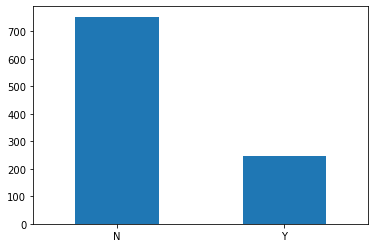

In [9]:
# Bar plot of fraud_reported column values
insurance_df['fraud_reported'].value_counts().plot(kind='bar', rot=0)

In [10]:
# Replace the fraud_reported column values Y and N with 0 and 1
insurance_df = insurance_df.replace({'fraud_reported': {'Y': 1, 'N': 0}})
insurance_df.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductible,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


### Convert categorical variables with OneHotEncoding

In [11]:
# Split our preprocessed data for target array and OneHotEncoder
y = insurance_df["fraud_reported"].values
X_df = insurance_df.drop(["fraud_reported"],1)

In [12]:
# Generate our categorical variable lists
X_cat = X_df.dtypes[X_df.dtypes == "object"].index.tolist()

In [13]:
# Check the number of unique values in each column
X_df[X_cat].nunique()

policy_state                3
policy_csl                  3
insured_sex                 2
insured_education_level     7
insured_occupation         14
insured_hobbies            20
insured_relationship        6
incident_type               4
collision_type              4
incident_severity           4
authorities_contacted       5
incident_state              7
incident_city               7
property_damage             3
police_report_available     3
auto_make                  14
auto_model                 39
dtype: int64

In [14]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(X_df[X_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(X_cat)
encode_df.head()

,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,policy_csl_250/500,policy_csl_500/1000,insured_sex_FEMALE,insured_sex_MALE,insured_education_level_Associate,insured_education_level_College,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Merge one-hot encoded features and drop the originals
X_df = X_df.merge(encode_df,left_index=True,right_index=True)
X_df = X_df.drop(X_cat,1)
X_df.head()

,months_as_customer,age,policy_deductible,policy_annual_premium,umbrella_limit,capital_gains,capital_loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,328,48,1000,1406.91,0,53300,0,5,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,228,42,2000,1197.22,5000000,0,0,8,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,134,29,2000,1413.14,5000000,35100,0,7,3,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,256,41,2000,1415.74,6000000,48900,-62400,5,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,228,44,1000,1583.91,6000000,66000,-46000,20,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split and scale data

In [16]:
# Set variable for our features array
X = X_df.values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [17]:
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
len(X_train[0])

161

### Compile, Train and Evaluate the Model

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 320
hidden_nodes_layer2 = 160

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               51840     
                                                                 
 dense_1 (Dense)             (None, 160)               51360     
                                                                 
 dense_2 (Dense)             (None, 1)                 161       
                                                                 
Total params: 103,361
Trainable params: 103,361
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [21]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Create a callback that saves the model's weights every 10 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=240)

In [23]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
24/24 [==============================] - 1s 2ms/step - loss: 0.5728 - accuracy: 0.7227
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.3164 - accuracy: 0.8733
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.1969 - accuracy: 0.9453
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.1175 - accuracy: 0.9733
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9933
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.9987
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 1.0000
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 1.0000
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 10/100
 1/24 [>.............................] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000
Epoch 10: sav

24/24 [==============================] - 0s 2ms/step - loss: 2.5401e-05 - accuracy: 1.0000
Epoch 72/100
24/24 [==============================] - 0s 2ms/step - loss: 2.4500e-05 - accuracy: 1.0000
Epoch 73/100
24/24 [==============================] - 0s 2ms/step - loss: 2.3681e-05 - accuracy: 1.0000
Epoch 74/100
24/24 [==============================] - 0s 2ms/step - loss: 2.2820e-05 - accuracy: 1.0000
Epoch 75/100
24/24 [==============================] - 0s 2ms/step - loss: 2.2078e-05 - accuracy: 1.0000
Epoch 76/100
24/24 [==============================] - 0s 2ms/step - loss: 2.1353e-05 - accuracy: 1.0000
Epoch 77/100
24/24 [==============================] - 0s 2ms/step - loss: 2.0607e-05 - accuracy: 1.0000
Epoch 78/100
24/24 [==============================] - 0s 2ms/step - loss: 1.9955e-05 - accuracy: 1.0000
Epoch 79/100
24/24 [==============================] - 0s 2ms/step - loss: 1.9312e-05 - accuracy: 1.0000
Epoch 80/100
 1/24 [>.............................] - ETA: 0s - loss: 1.5431e

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 1.5205 - accuracy: 0.7920 - 150ms/epoch - 19ms/step
Loss: 1.5204585790634155, Accuracy: 0.7919999957084656


In [25]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity.h5")